## Initial import

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn as sk
import os

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from graphviz import Source
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

from mlxtend.plotting import plot_confusion_matrix
from imblearn.over_sampling import SMOTE

In [ ]:
import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.losses as loss

In [ ]:
RANDOM_STATE = 2023
np.random.seed(RANDOM_STATE)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
images_dir = '/content/drive/MyDrive/progetto_robotica/images'
dataset_dir = '/content/drive/MyDrive/progetto_robotica/datasets'
PROJECT_ROOT_DIR = "."

Mounted at /content/drive


In [ ]:
errors = pd.read_csv(os.path.join(dataset_dir, "PdM_errors.csv"))
failures = pd.read_csv(os.path.join(dataset_dir, "PdM_failures.csv"))
machines = pd.read_csv(os.path.join(dataset_dir, "PdM_machines.csv"))
maint = pd.read_csv(os.path.join(dataset_dir, "PdM_maint.csv"))
telemetry = pd.read_csv(os.path.join(dataset_dir, "PdM_telemetry.csv"))

In [ ]:
def clf_testing(clf,clf_name, class_names, x_test, y_test):
  y_pred = clf.predict(x_test)
  report = classification_report(y_test, y_pred, digits=5, target_names=class_names)
  accuracy = accuracy_score(y_test,y_pred)
  print(clf)
  print(report)
  fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test,y_pred), show_absolute = True, show_normed = True, colorbar = True)
  ax.set_xticklabels([''] + class_names)
  ax.set_yticklabels([''] + class_names)
  fig.savefig(f"{images_dir}/conf_matr_{clf_name}.png")

In [ ]:
def importance_features(clf,clf_name,features_names):
  fig, axes = plt.subplots(figsize=(15,5))
  axes.bar(range(len(clf.feature_importances_)), clf.feature_importances_, tick_label=features_names[:-1])
  plt.savefig(f"{images_dir}/impo_features_{clf_name}.png")

## Feature analysis

In [ ]:
class_names = ['no failure', 'comp1','comp2','comp3','comp4',]

In [ ]:
machines['model'].value_counts()

model3    35
model4    32
model2    17
model1    16
Name: model, dtype: int64

Join machines and telemetry in order to use only machine of one type (model3) for an initial study. Same procedure can be later used for others models.

In [ ]:
df = telemetry.copy()
df = pd.merge(telemetry,machines, on=['machineID'])
df = pd.merge(df, failures, how='outer', on=['machineID','datetime'])

In [ ]:
df['model'][df['model']=='model1']=1
df['model'][df['model']=='model2']=2
df['model'][df['model']=='model3']=3
df['model'][df['model']=='model4']=4

df['failure'][df['failure'].isna()]=0
df['failure'][df['failure']=='comp1']=1
df['failure'][df['failure']=='comp2']=2
df['failure'][df['failure']=='comp3']=3
df['failure'][df['failure']=='comp4']=4

In [ ]:
df['failure'].value_counts()

0    875381
2       259
1       192
4       179
3       131
Name: failure, dtype: int64

In [ ]:
sensors = ['volt','rotate','pressure','vibration']

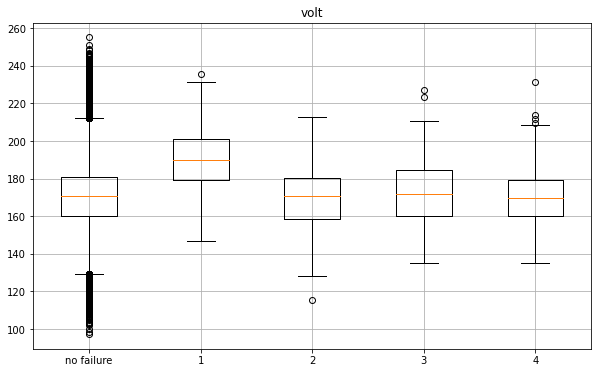

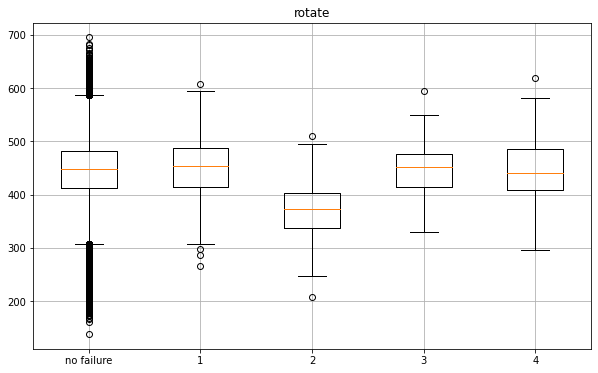

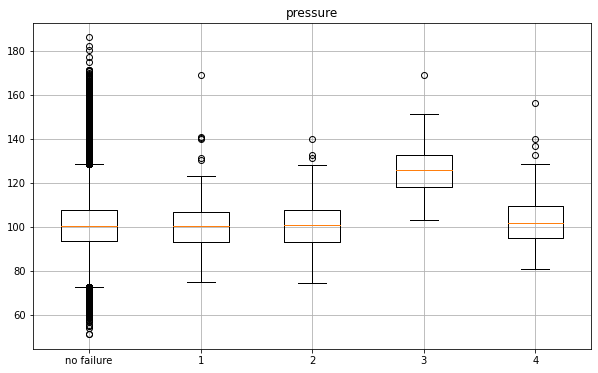

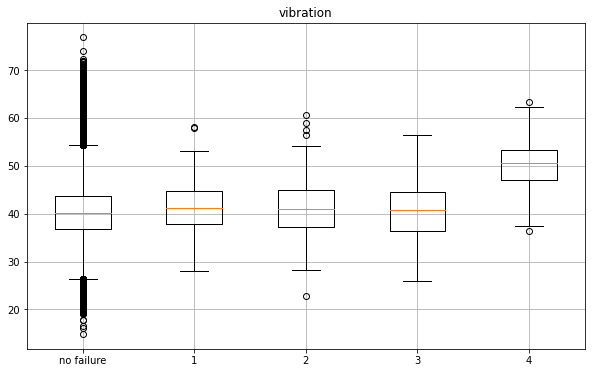

In [ ]:
for f in range(4):
  fig, ax = plt.subplots(figsize=(10,6))
  ax.set_title(f'{df.columns[f+2]}')
  ax.boxplot(x=[df[df['failure'] == 0][df.columns[f+2]],
                df[df['failure'] == 1][df.columns[f+2]],
                df[df['failure'] == 2][df.columns[f+2]],
                df[df['failure'] == 3][df.columns[f+2]],
                df[df['failure'] == 4][df.columns[f+2]]],
             labels=['no failure','1','2','3','4'])
  ax.grid()
  
  fig.savefig(f"{images_dir}/boxplot_feature_{df.columns[f+2]}.png")

Every type of component failed correspond to bigger/lower curve of only a  feature, we try to plot in order to identify the shape of the graph in proximity of failures

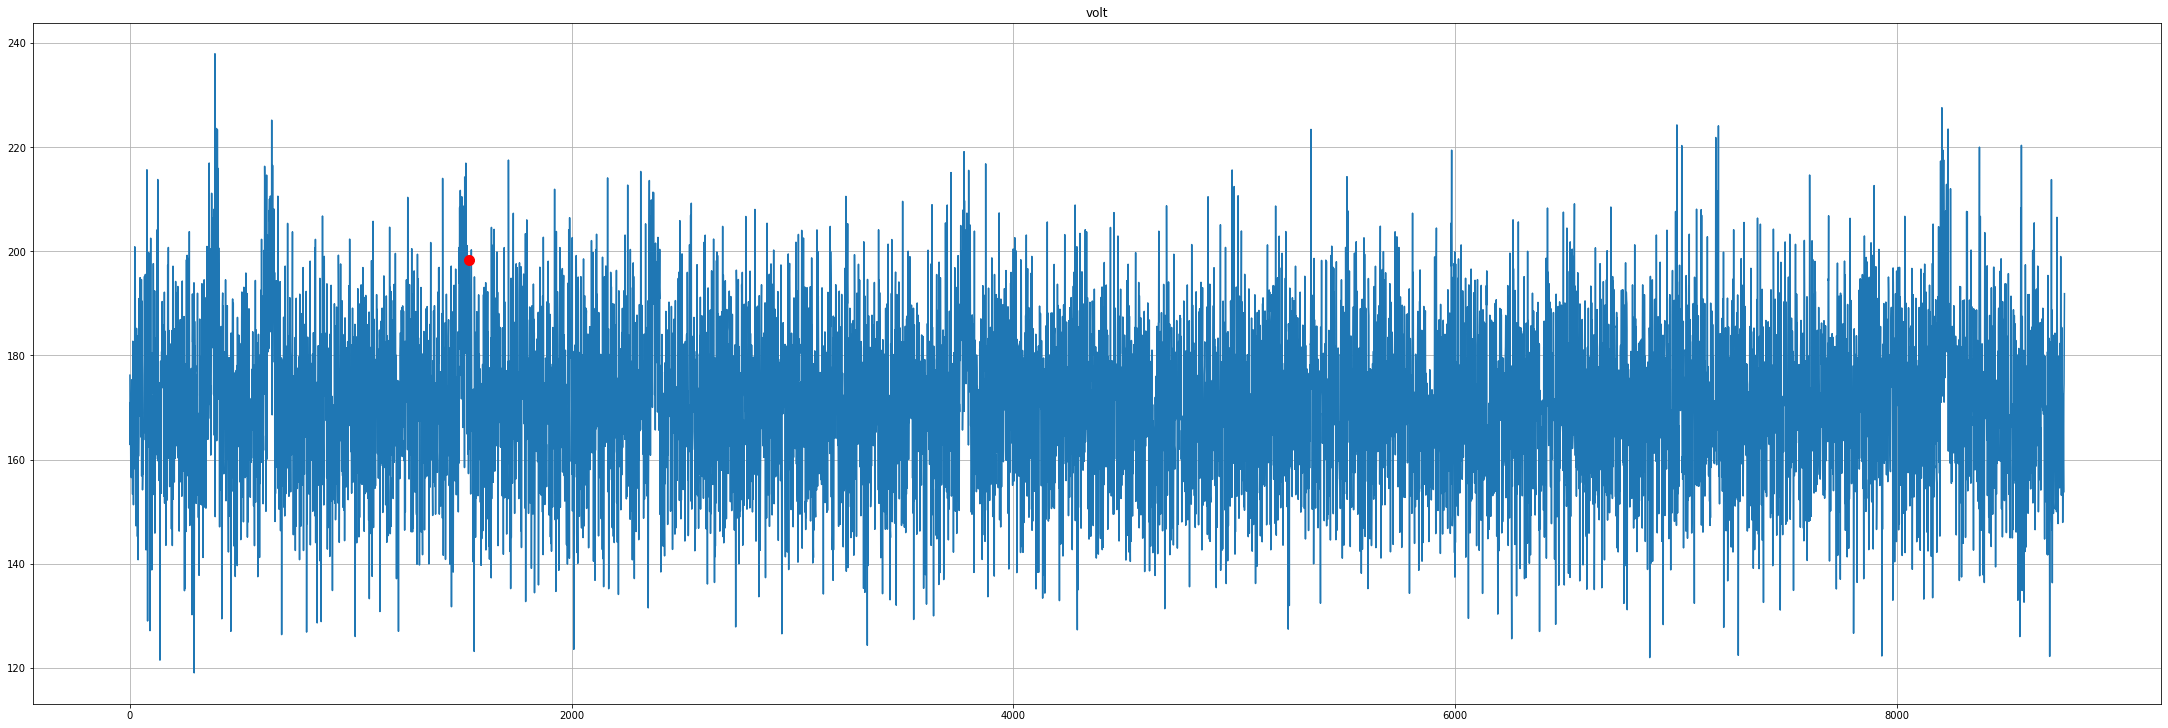

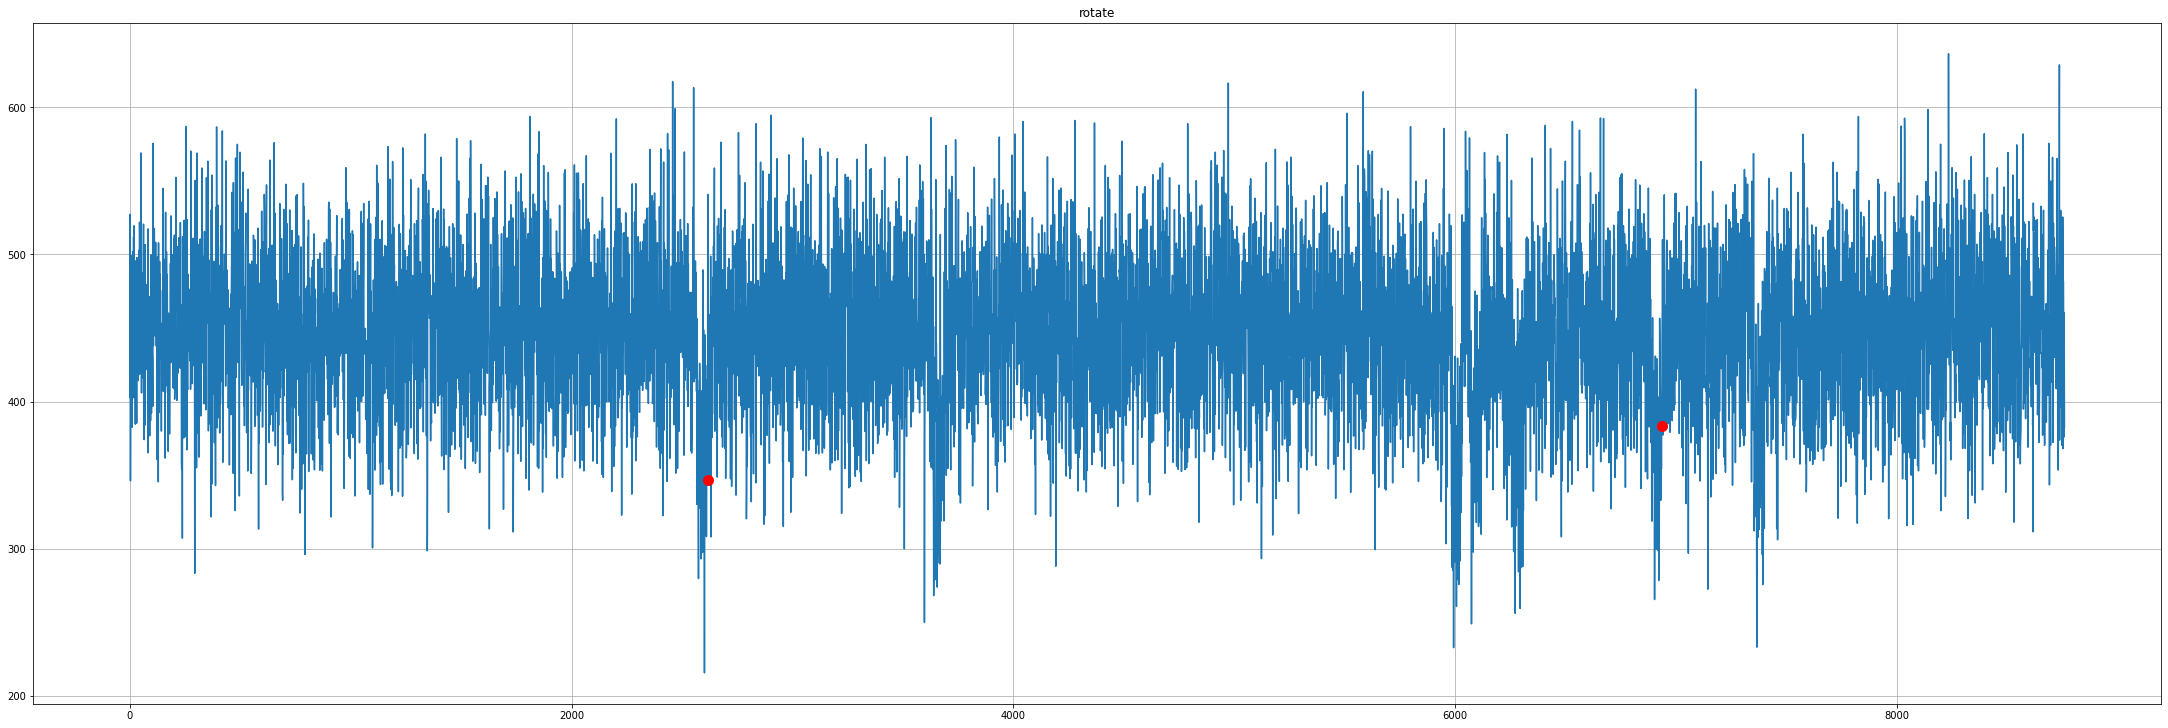

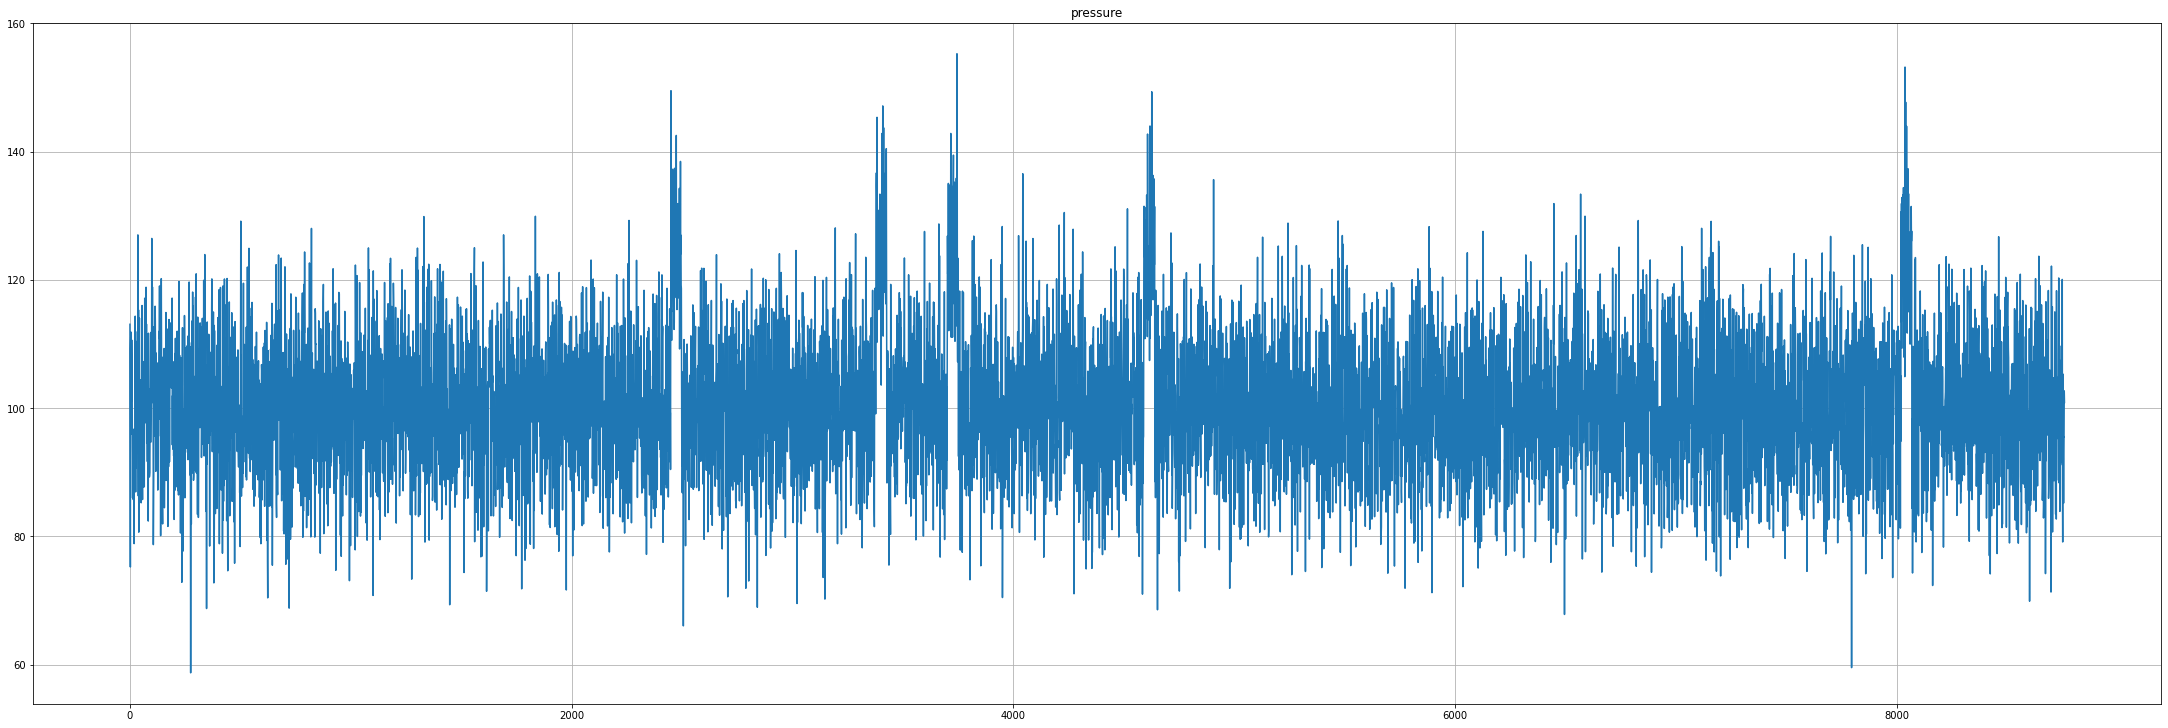

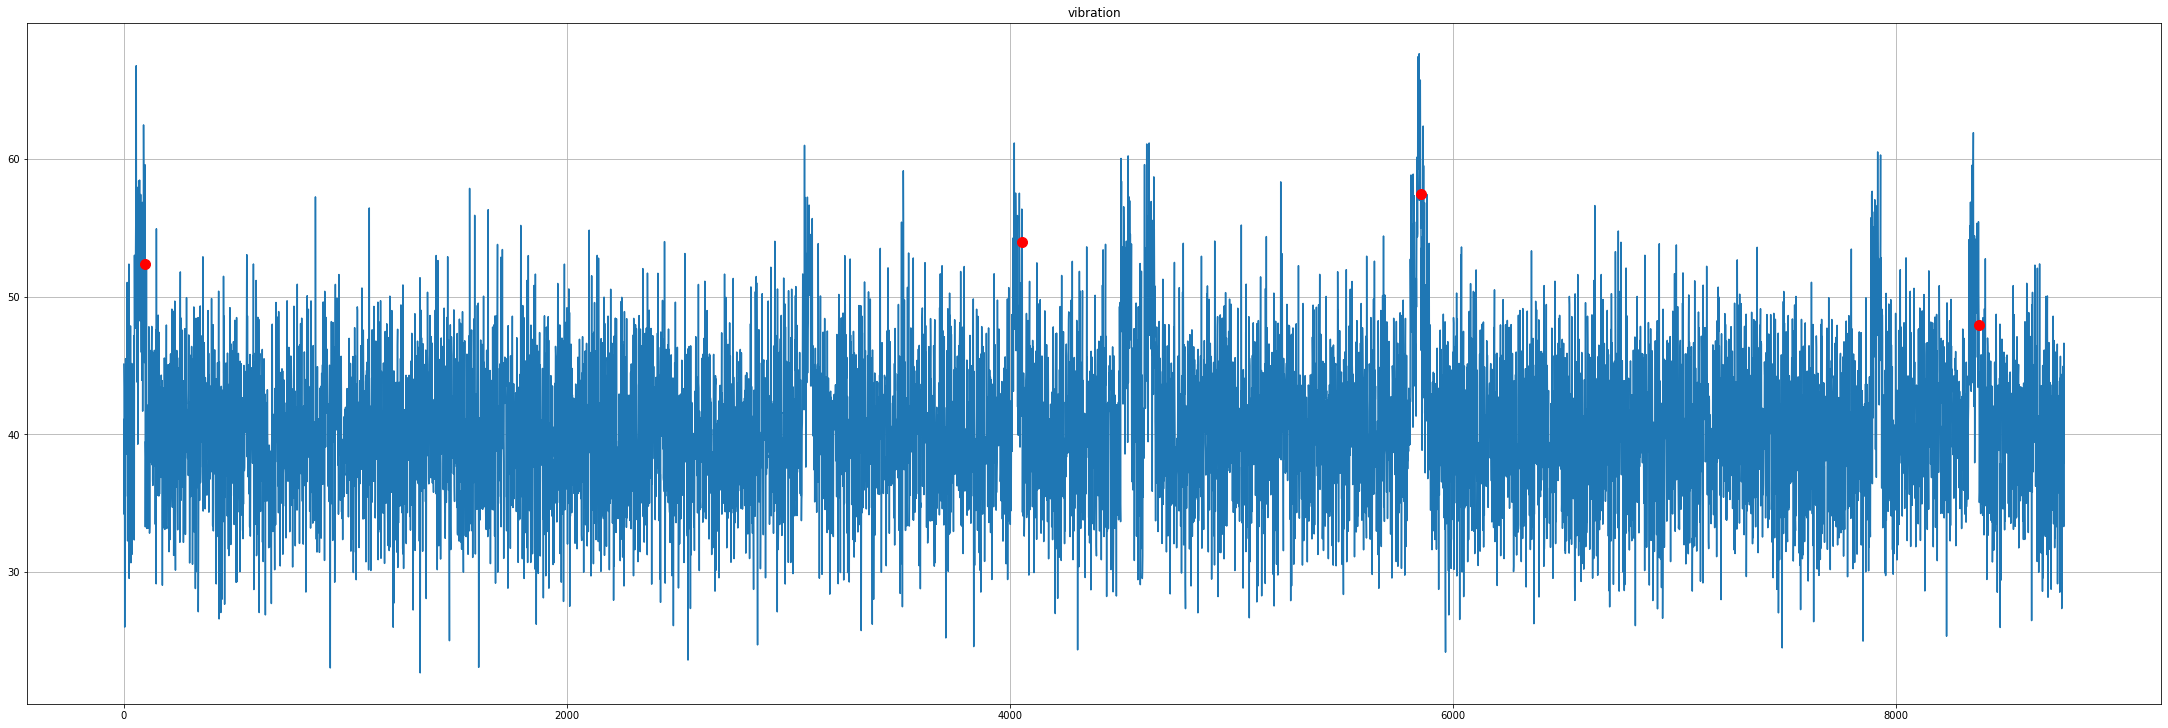

In [ ]:
machine = df[df['machineID'] == 1]
#machine = machine[4000:] #zoom for vibration
machine.set_index('datetime')

for i in range(4):
  fig, ax = plt.subplots(figsize=(30,10), constrained_layout=True)
  plt.title(df.columns[i+2])
  ax.plot(machine[df.columns[i+2]])
  ax.plot(machine[machine['failure'] == i+1][df.columns[i+2]], marker='o', markersize=10, color="red", linestyle=' ')
  ax.grid()
  fig.savefig(f"{images_dir}/graph_machine1_{df.columns[i+2]}.png")

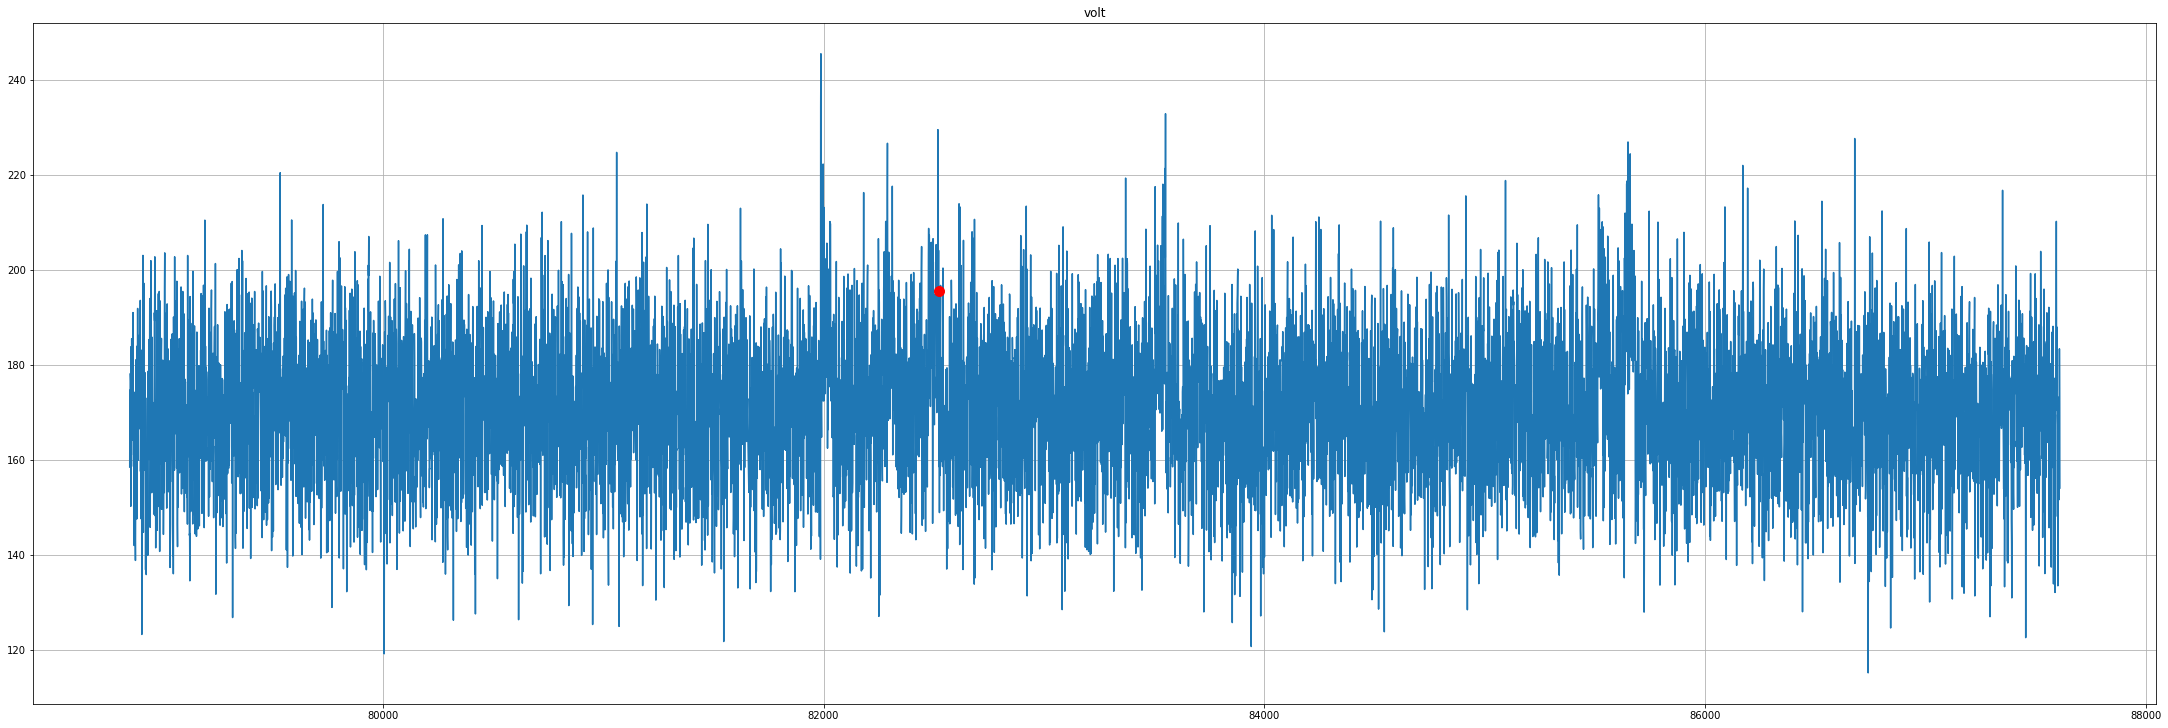

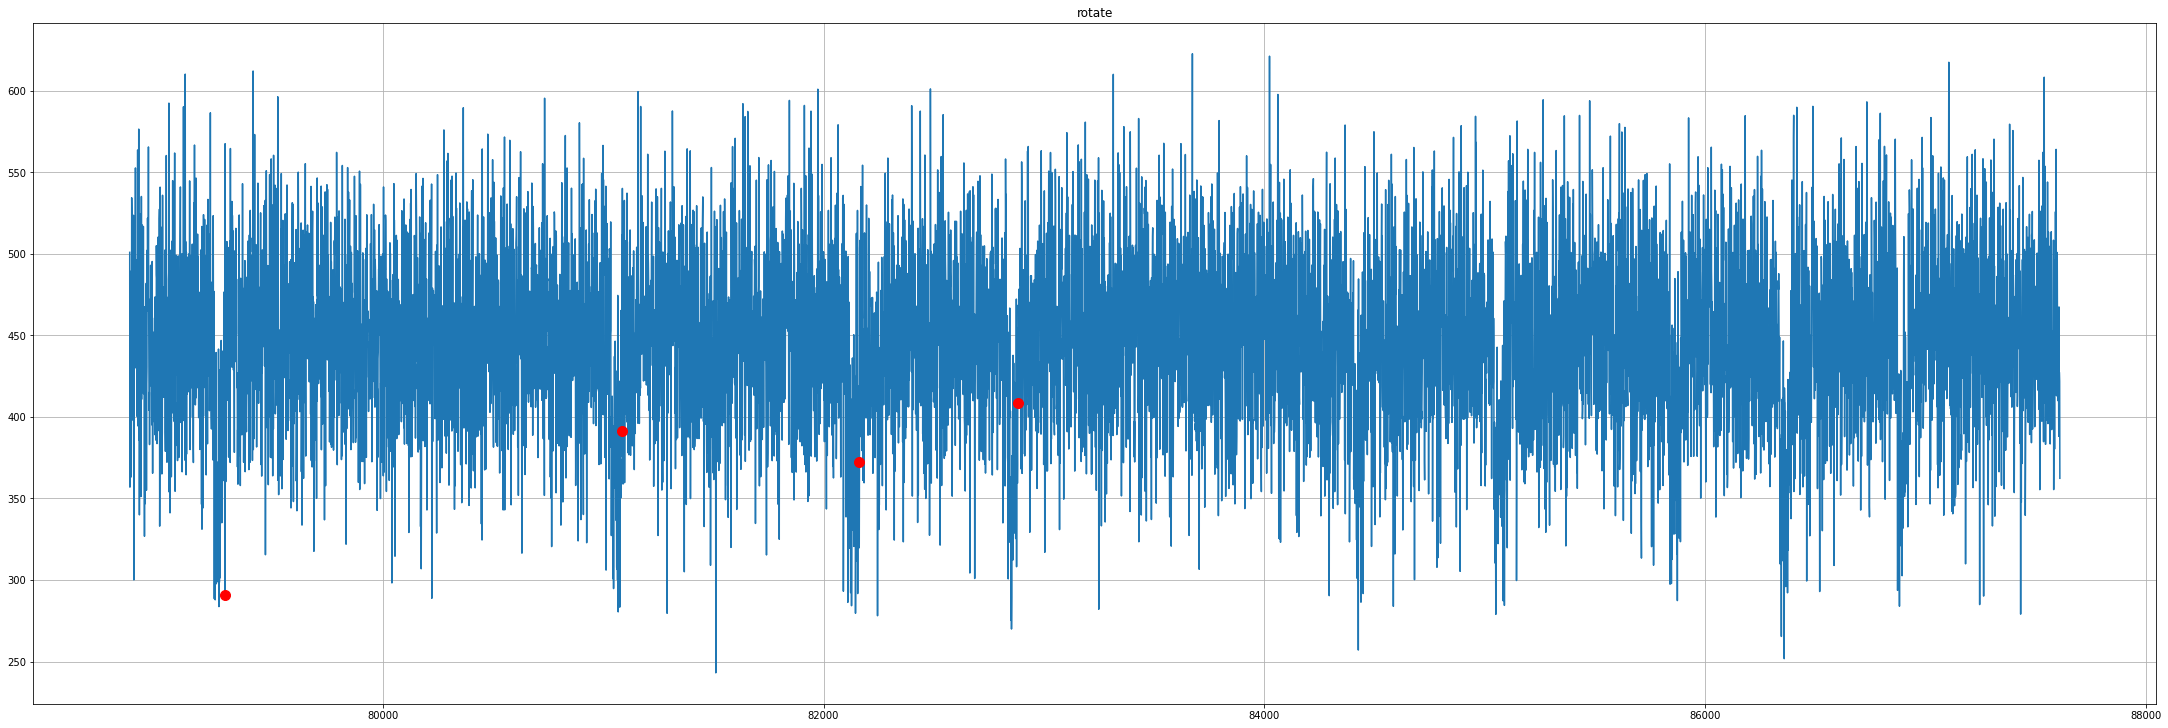

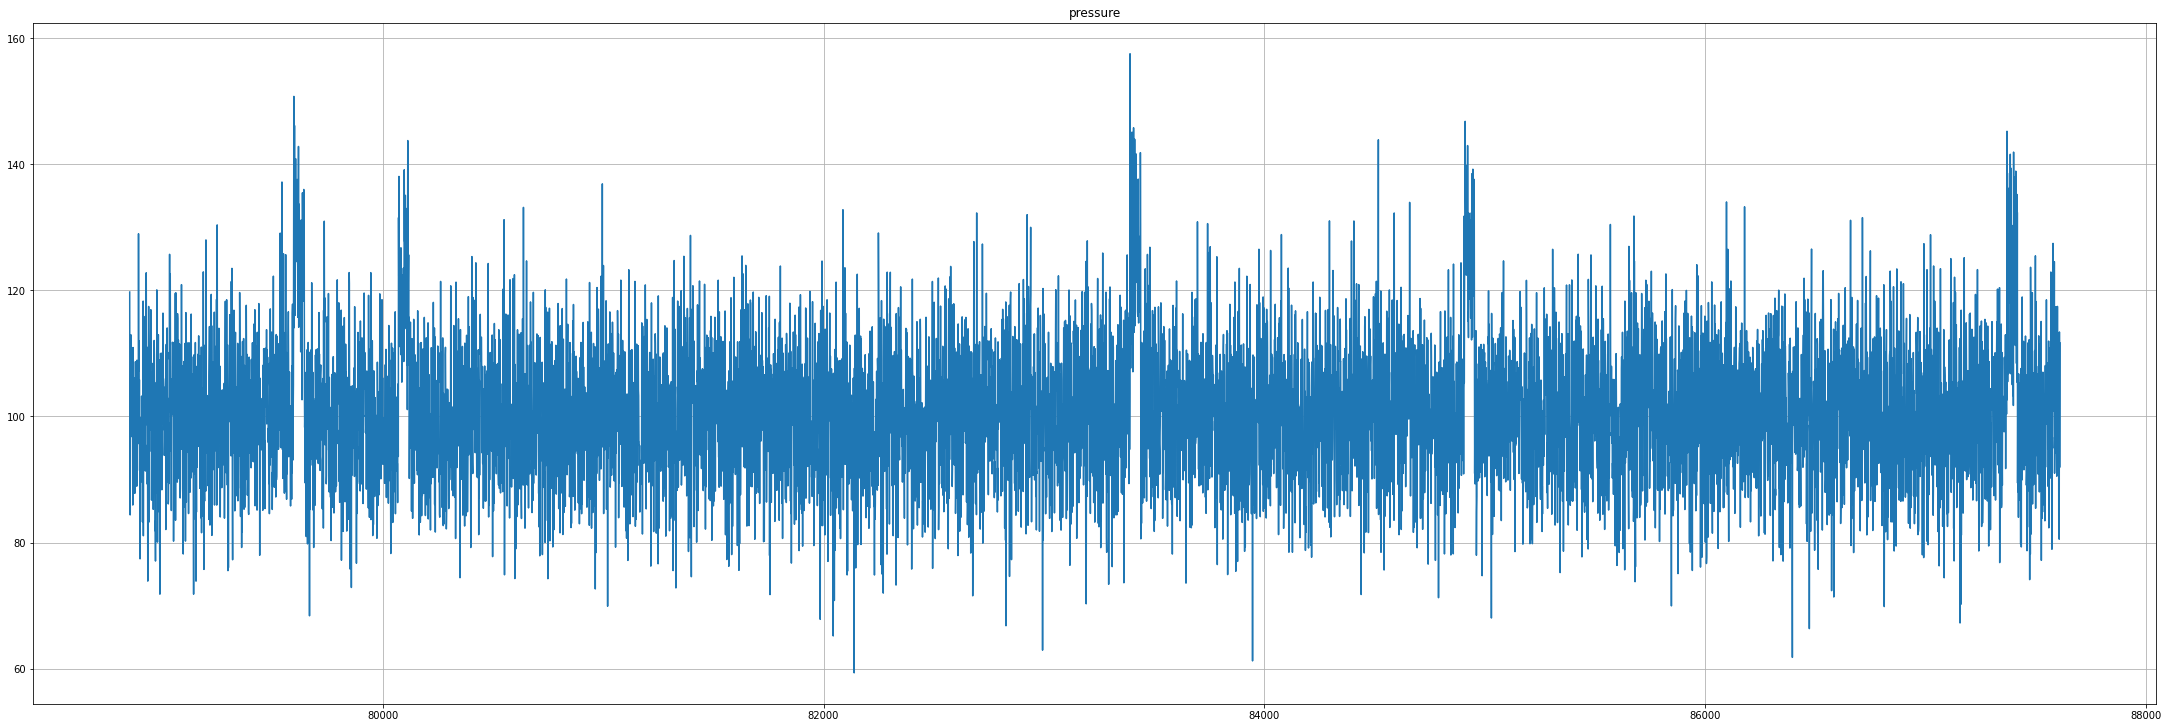

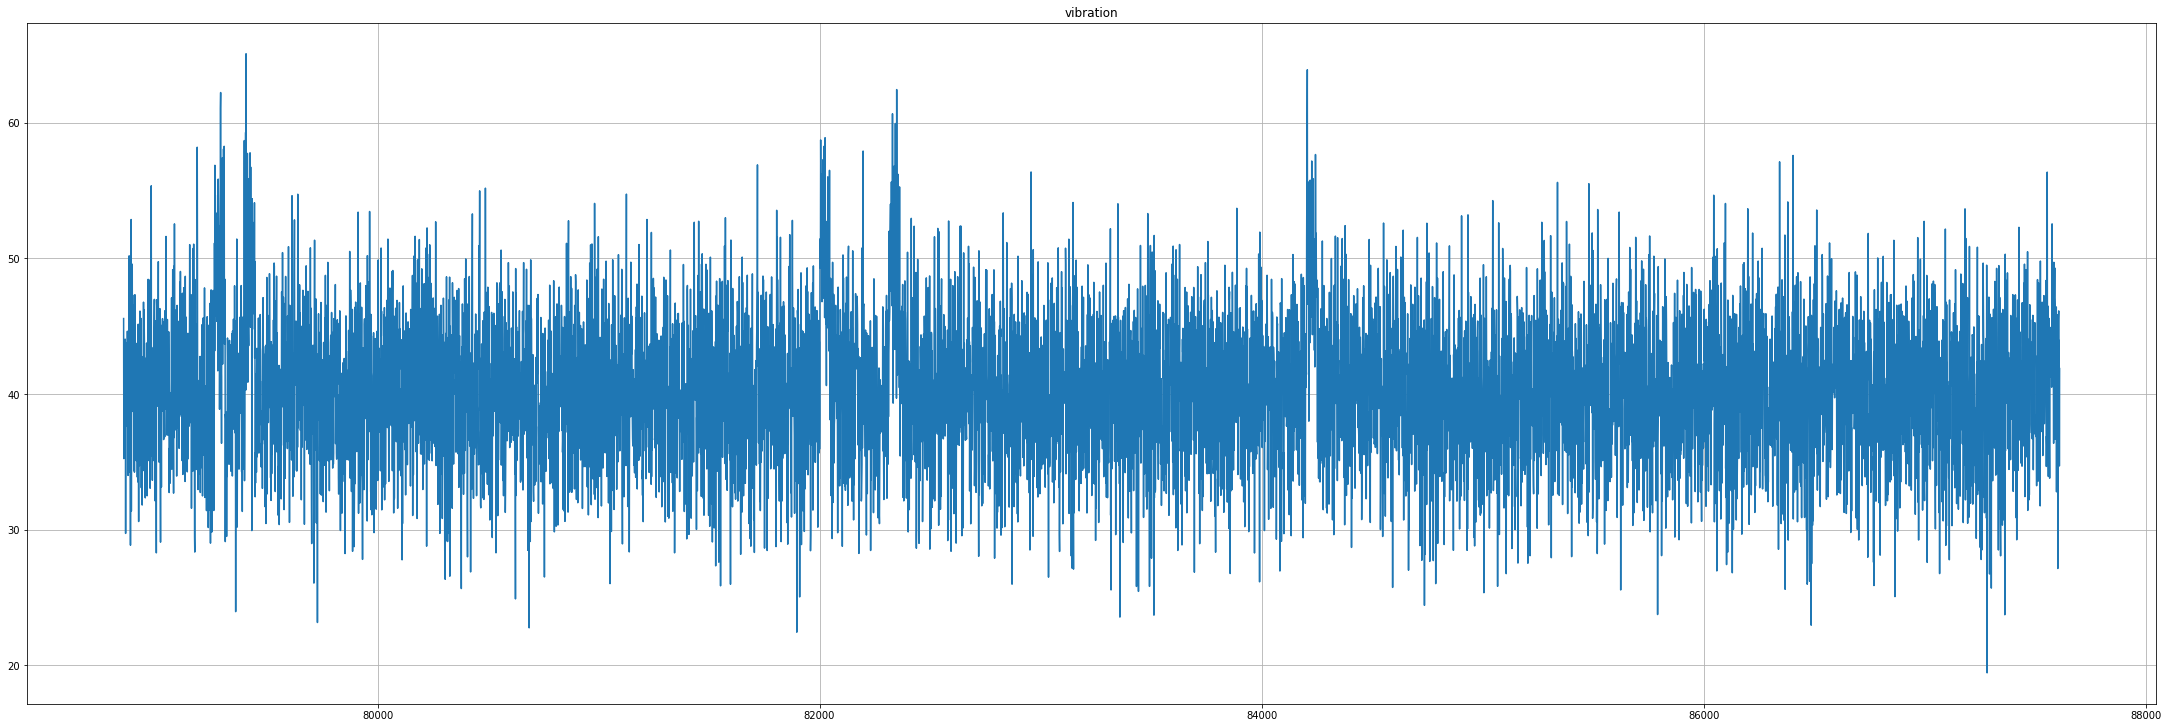

In [ ]:
machine = df[df['machineID'] == 10]
#machine = machine[2000:5000]  #zoom on failure associate to rotate feature
machine.set_index('datetime')

for i in range(4):
  fig, ax = plt.subplots(figsize=(30,10), constrained_layout=True)
  plt.title(df.columns[i+2])
  ax.plot(machine[df.columns[i+2]])
  ax.plot(machine[machine['failure'] == i+1][df.columns[i+2]], marker='o', markersize=10, color="red", linestyle=' ')
  ax.grid()
  fig.savefig(f"{images_dir}/graph_machine10_{df.columns[i+2]}.png")

We try with moving average to see better the correlation between sensors valure and component failures.
We first calculate the autocorrelation and partial autocorrelation to set a significant average window.

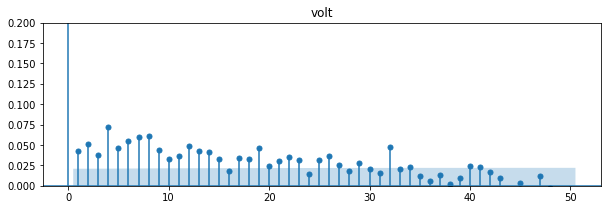

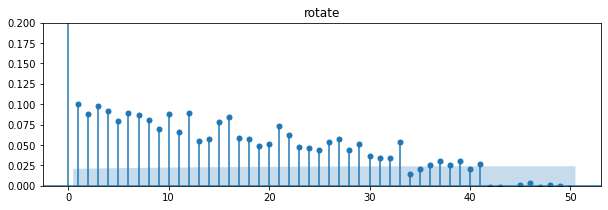

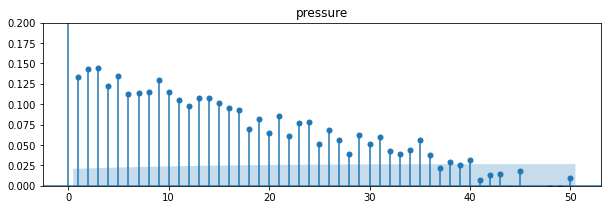

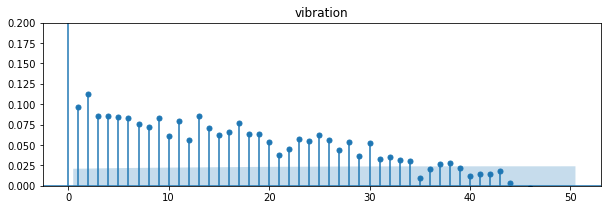

In [ ]:
for i in range(4):
  fig, ax = plt.subplots(sharex=True, figsize=(10,3))
  plot_acf(machine[df.columns[i+2]], ax=ax, lags = 50)
  plt.title(sensors[i])
  ax.set_ylim([0,0.2])
  plt.show()
  fig.savefig(f"{images_dir}/autocorrelation_{df.columns[i+2]}.png")

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


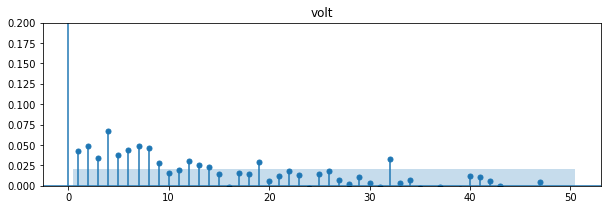

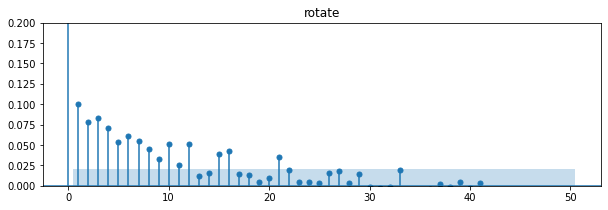

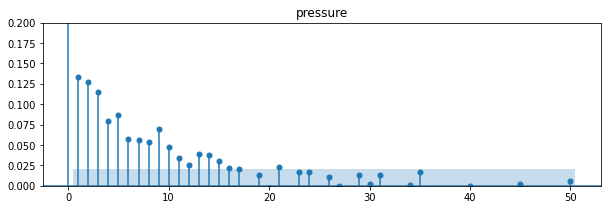

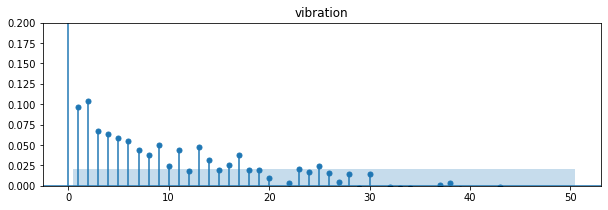

In [ ]:
for i in range(4):
  fig, ax = plt.subplots(sharex=True, figsize=(10,3))
  plot_pacf(machine[df.columns[i+2]], ax=ax, lags = 50)
  plt.title(sensors[i])
  ax.set_ylim([0,0.2])
  plt.show()
  fig.savefig(f"{images_dir}/partial_autocorrelation_{df.columns[i+2]}.png")

In [ ]:
rolling_window = 24

df_mov = df.copy()
df_mov.set_index('datetime')
for i in range(4):
  df_mov['average_'+sensors[i]] = df_mov[sensors[i]].rolling(rolling_window).mean()
  df_mov.dropna(inplace=True)
df_mov.head()

,datetime,machineID,volt,rotate,pressure,vibration,model,age,failure,average_volt,average_rotate,average_pressure,average_vibration
92,2015-01-05 02:00:00,1,158.155297,429.346217,94.892589,58.225151,3,18,0,171.372335,442.824640,99.159077,52.076521
93,2015-01-05 03:00:00,1,177.317220,461.801246,103.056344,49.894647,3,18,0,170.757841,440.958228,98.716746,51.746749
94,2015-01-05 04:00:00,1,202.520488,387.005318,94.686208,45.202347,3,18,0,171.047655,441.077662,98.222303,51.561122
95,2015-01-05 05:00:00,1,177.510419,469.787301,100.498426,59.577251,3,18,0,171.333562,441.310894,98.087115,51.607772
96,2015-01-05 06:00:00,1,179.303153,499.777962,111.833028,52.383097,3,18,4,171.929104,443.448775,98.675590,51.780445


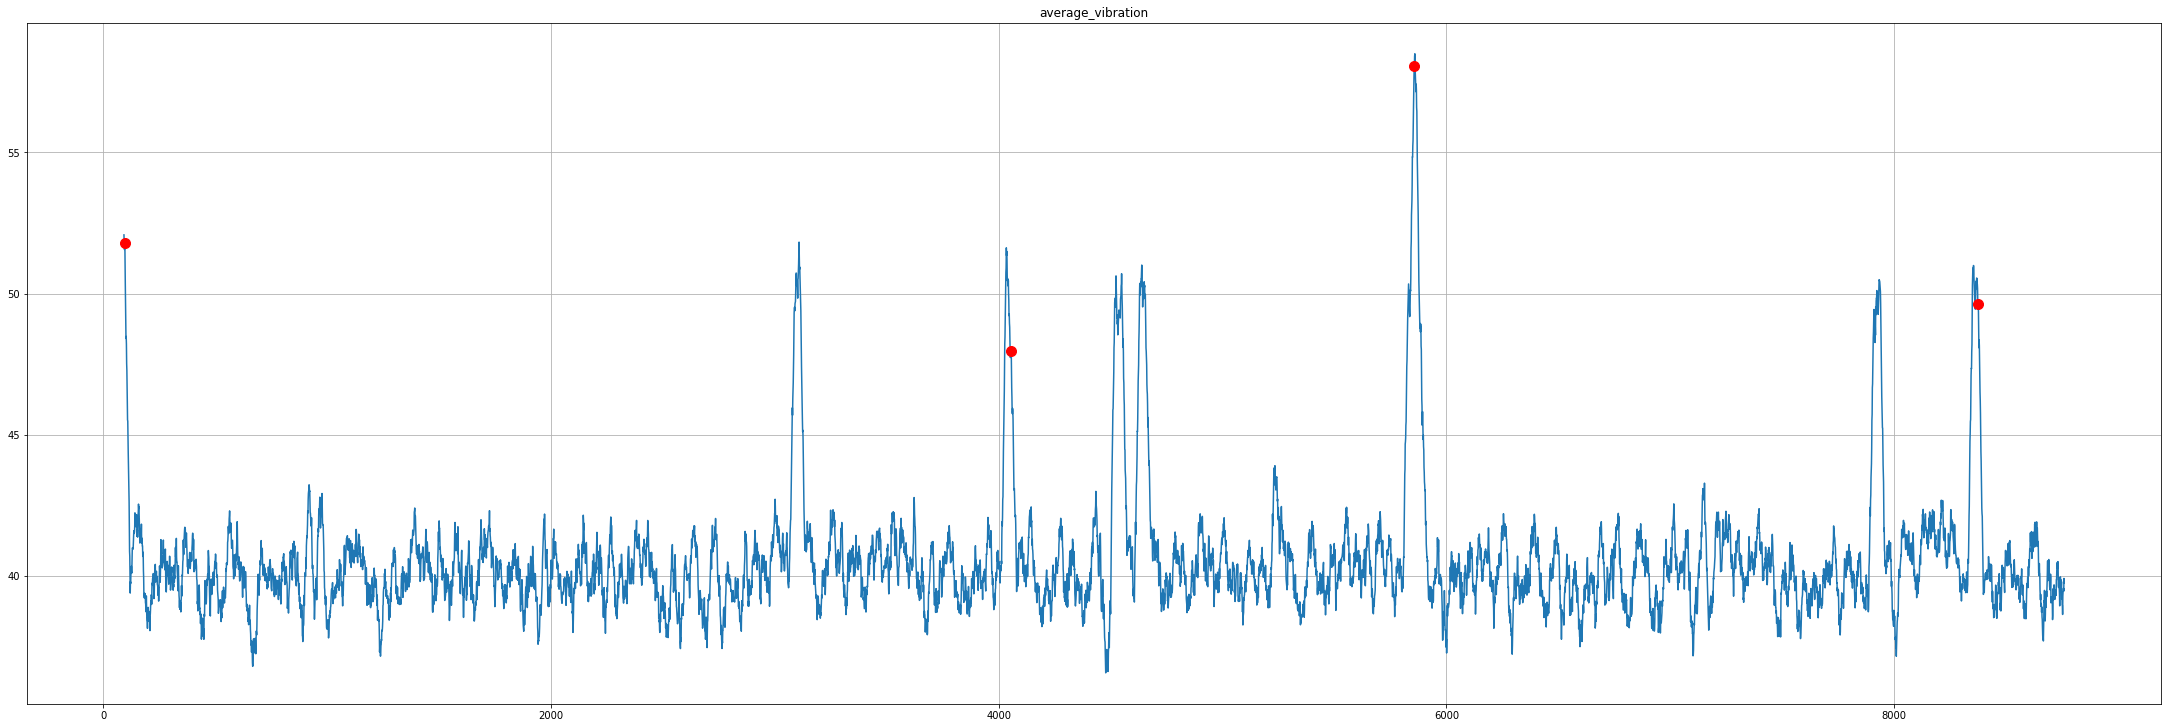

In [ ]:
to_plot = 'average_vibration'
machine_id = 1
failure_id = 4

df_mov_machine = df_mov[df_mov['machineID'] == machine_id]
fig, ax = plt.subplots(figsize=(30,10), constrained_layout=True)
plt.title(to_plot)

ax.plot(df_mov_machine[to_plot])
ax.plot(df_mov_machine[df_mov_machine['failure'] == failure_id][to_plot], marker='o', markersize=10, color="red", linestyle=' ')
ax.grid()

fig.savefig(f"{images_dir}/moving_machine1_vibration.png")

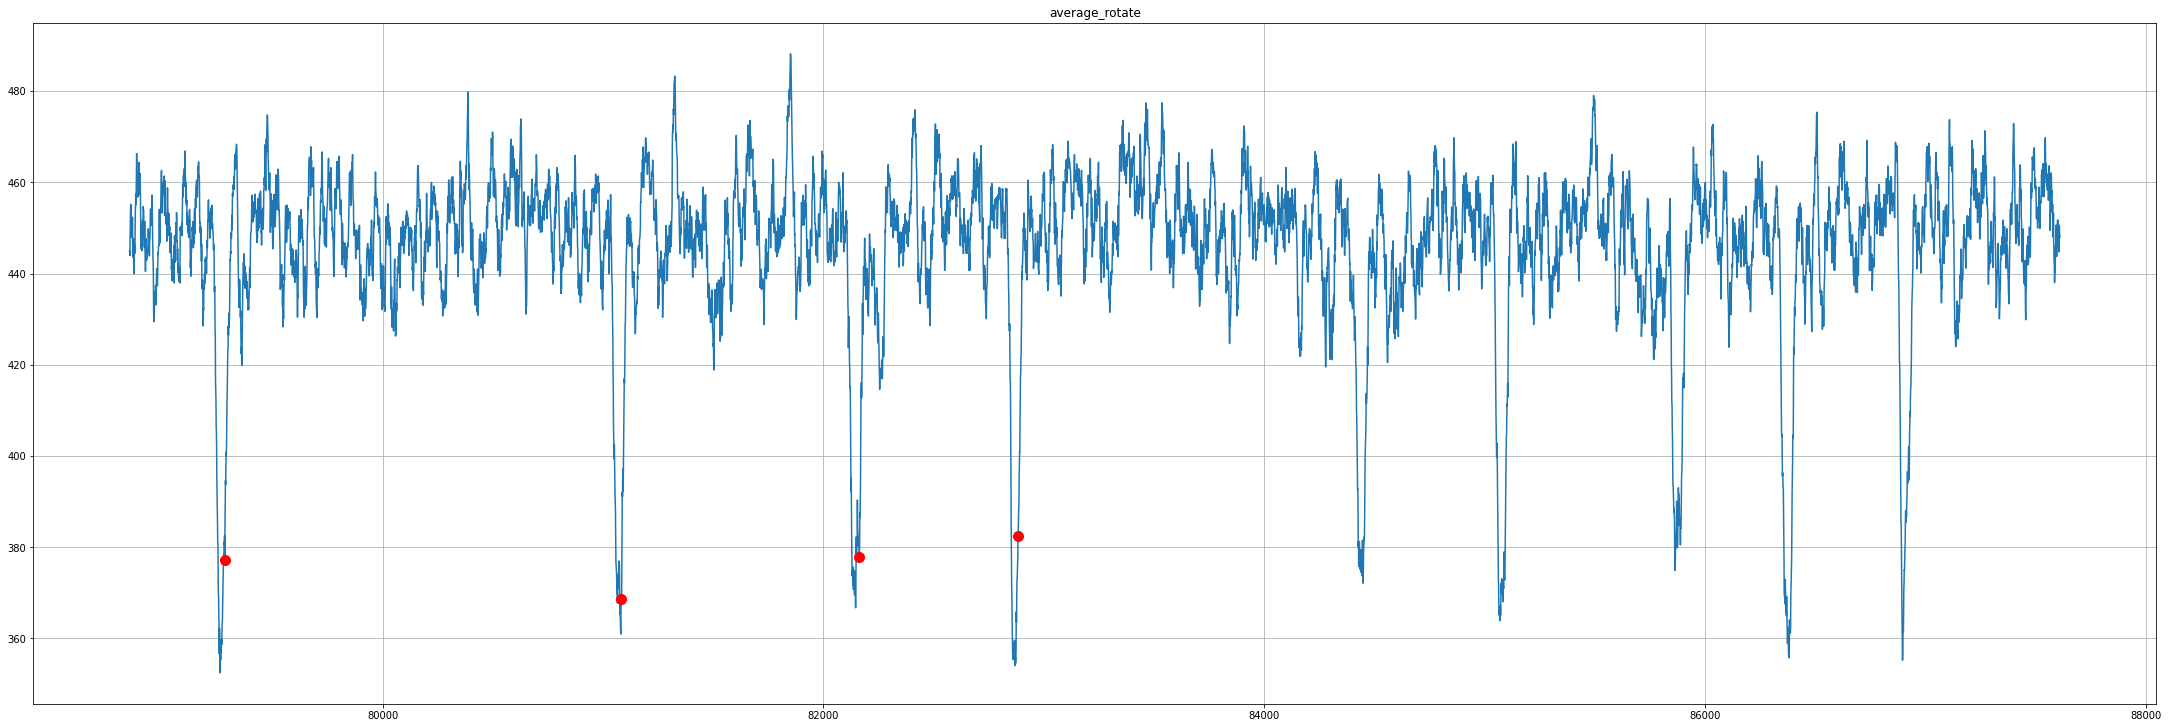

In [ ]:
to_plot = 'average_rotate'
machine_id = 10
failure_id = 2

df_mov_machine = df_mov[df_mov['machineID'] == machine_id]
fig, ax = plt.subplots(figsize=(30,10), constrained_layout=True)
plt.title(to_plot)

ax.plot(df_mov_machine[to_plot])
ax.plot(df_mov_machine[df_mov_machine['failure'] == failure_id][to_plot], marker='o', markersize=10, color="red", linestyle=' ')
ax.grid()
fig.savefig(f"{images_dir}/moving_machine10_rotate.png")

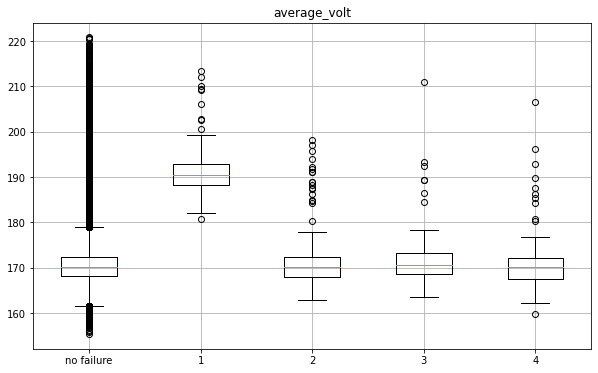

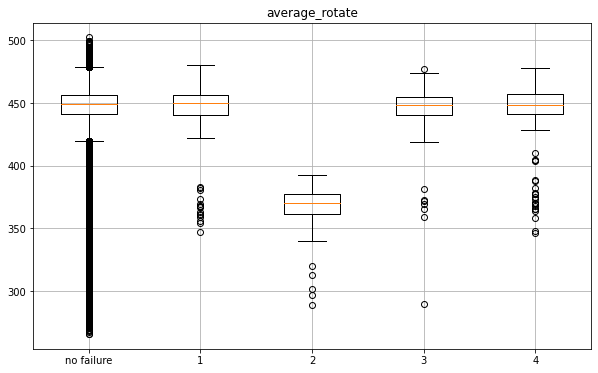

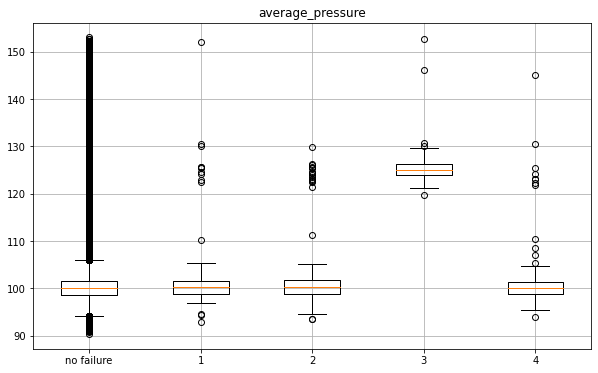

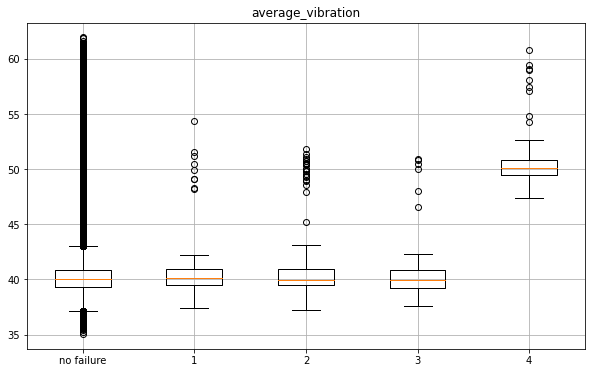

In [ ]:
for f in range(4):
  fig, ax = plt.subplots(figsize=(10,6))
  ax.set_title(f'{df_mov.columns[f+9]}')
  ax.boxplot(x=[df_mov[df_mov['failure'] == 0][df_mov.columns[f+9]],
                df_mov[df_mov['failure'] == 1][df_mov.columns[f+9]],
                df_mov[df_mov['failure'] == 2][df_mov.columns[f+9]],
                df_mov[df_mov['failure'] == 3][df_mov.columns[f+9]],
                df_mov[df_mov['failure'] == 4][df_mov.columns[f+9]]],
             labels=['no failure','1','2','3','4'])
  ax.grid()

  fig.savefig(f"{images_dir}/boxplot_feature_moving_{df.columns[f+2]}.png")


## Forecasting

In [ ]:
machine_id = 1
failure_id = 4
n_past = 24
test_ratio = 0.2

df_forecast = df[df['machineID'] == machine_id]
df_forecast.drop(['machineID', 'model', 'age', 'failure','datetime'], axis=1, inplace=True)

scaler = MinMaxScaler(feature_range=(0,1))
df_forecast = scaler.fit_transform(df_forecast)

x = []
y = []

for i in range(n_past, len(df_forecast)):
        x.append(df_forecast[i - n_past:i, 0:df_forecast.shape[1]])
        y.append(df_forecast[i, 0:df_forecast.shape[1]]) 

x = np.array(x)
y = np.array(y)

train_size = int((y.size * (1-test_ratio)) / 4)
x_train = x[:train_size]
x_test = x[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

<ipython-input-84-88265bc6c105>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_forecast.drop(['machineID', 'model', 'age', 'failure','datetime'], axis=1, inplace=True)


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
lstm=Sequential()
lstm.add(LSTM(20,activation='tanh', return_sequences=True ,input_shape=(n_past,4)))
lstm.add(LSTM(10,activation='tanh' ))
lstm.add(Dropout(0.2))
lstm.add(Dense(4))

lstm.compile(optimizer=optimizer, loss = "mse")

history=lstm.fit(x_train, y_train, epochs = 30, batch_size=100, validation_split=.2, verbose=1)

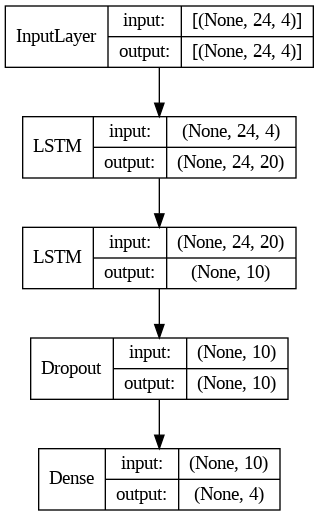

In [ ]:
tf.keras.utils.plot_model(lstm,  show_shapes=True,  show_layer_names=False)

In [ ]:
score = lstm.evaluate(x_test, y_test, verbose=1)
print(score)

55/55 [==============================] - 0s 8ms/step - loss: 0.0144
0.01438300870358944


55/55 [==============================] - 1s 7ms/step


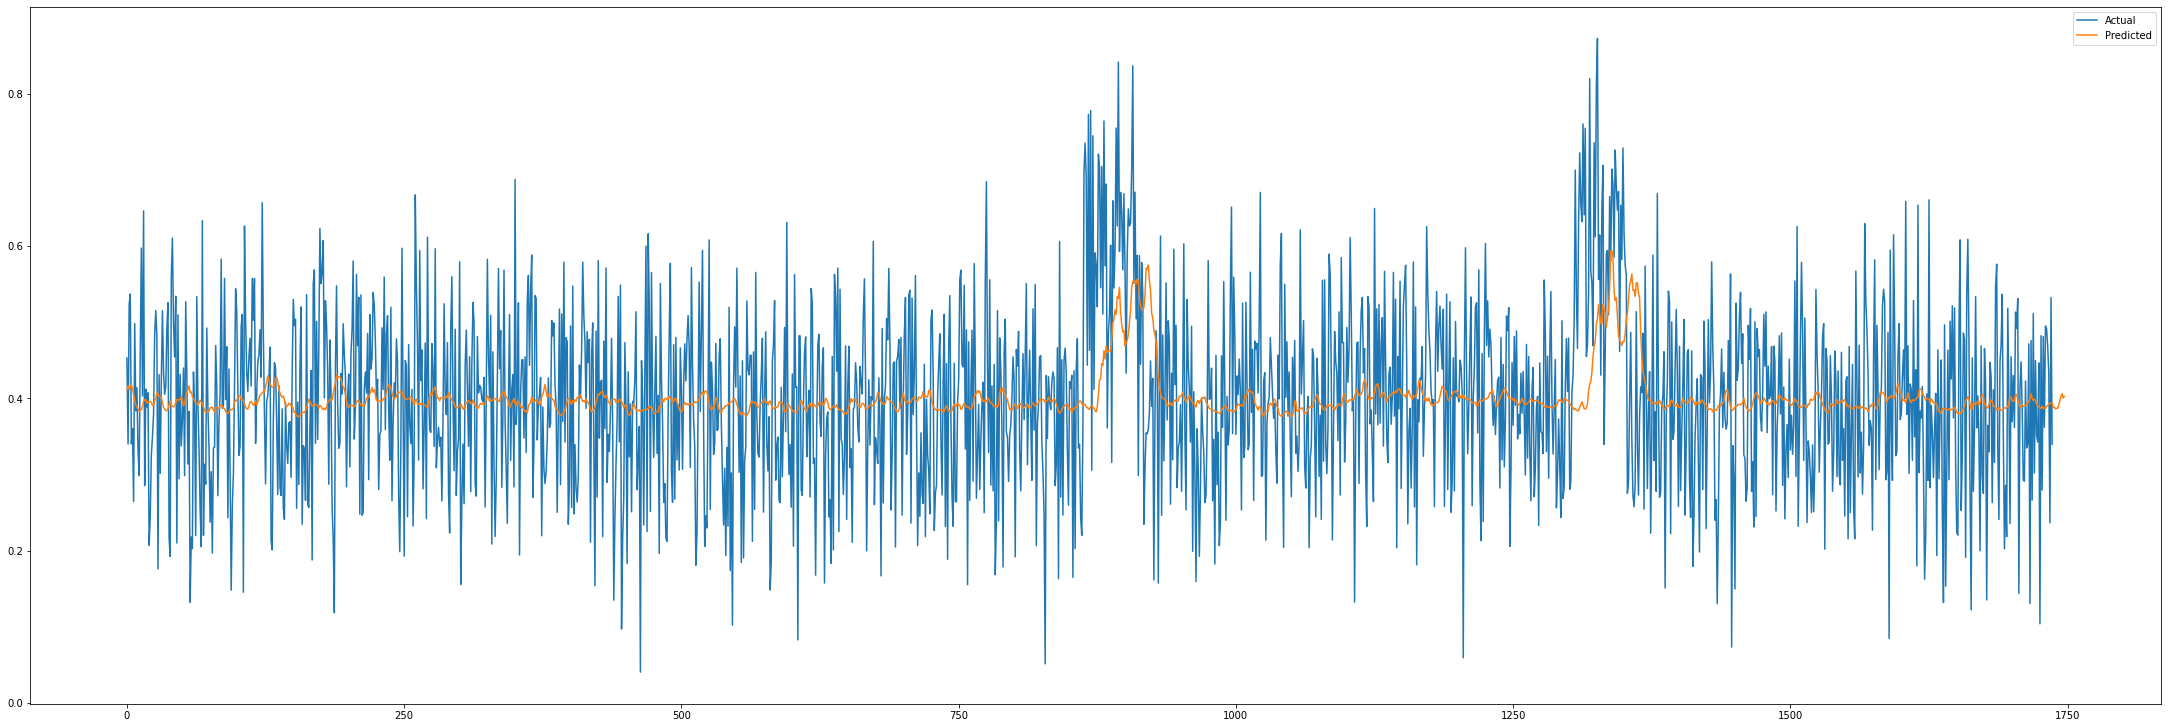

In [ ]:
y_pred=lstm.predict(x_test)

fig, ax = plt.subplots(figsize=(30,10), constrained_layout=True)
plt.plot(y[7000:,3],label='Actual')
plt.plot(y_pred[:,3],label='Predicted')
plt.legend()
plt.show()
fig.savefig(f"{images_dir}/lstm_machine1_vibration.png")

In [ ]:
rolling_window = 24

df_pred_mov = pd.DataFrame(y_pred)
df_pred_mov.head()
df_pred_mov['mov_average'] = df_pred_mov[3].rolling(rolling_window).mean()
df_pred_mov.dropna(inplace=True)
df_pred_mov.reset_index(drop=True, inplace=True)
df_pred_mov.head()

,0,1,2,3,mov_average
0,0.450716,0.562090,0.426954,0.382834,0.402790
1,0.457582,0.564699,0.426564,0.384072,0.400564
2,0.466389,0.568223,0.426889,0.384765,0.397955
3,0.466884,0.570440,0.428618,0.389206,0.396080
4,0.475019,0.574400,0.432092,0.396055,0.394505


In [ ]:
df_act_mov = pd.DataFrame(df_forecast)

df_act_mov['mov_average'] = df_act_mov[3].rolling(rolling_window).mean()
df_act_mov.dropna(inplace=True)
df_act_mov = df_act_mov[7000:]
df_act_mov.reset_index(drop=True, inplace=True)
df_act_mov.head()

,0,1,2,3,mov_average
0,0.289574,0.534064,0.273120,0.450104,0.445817
1,0.328200,0.646697,0.275166,0.319584,0.440918
2,0.399386,0.502578,0.449688,0.577461,0.435310
3,0.301177,0.625270,0.510300,0.316235,0.434564
4,0.541743,0.743257,0.437875,0.591479,0.434189


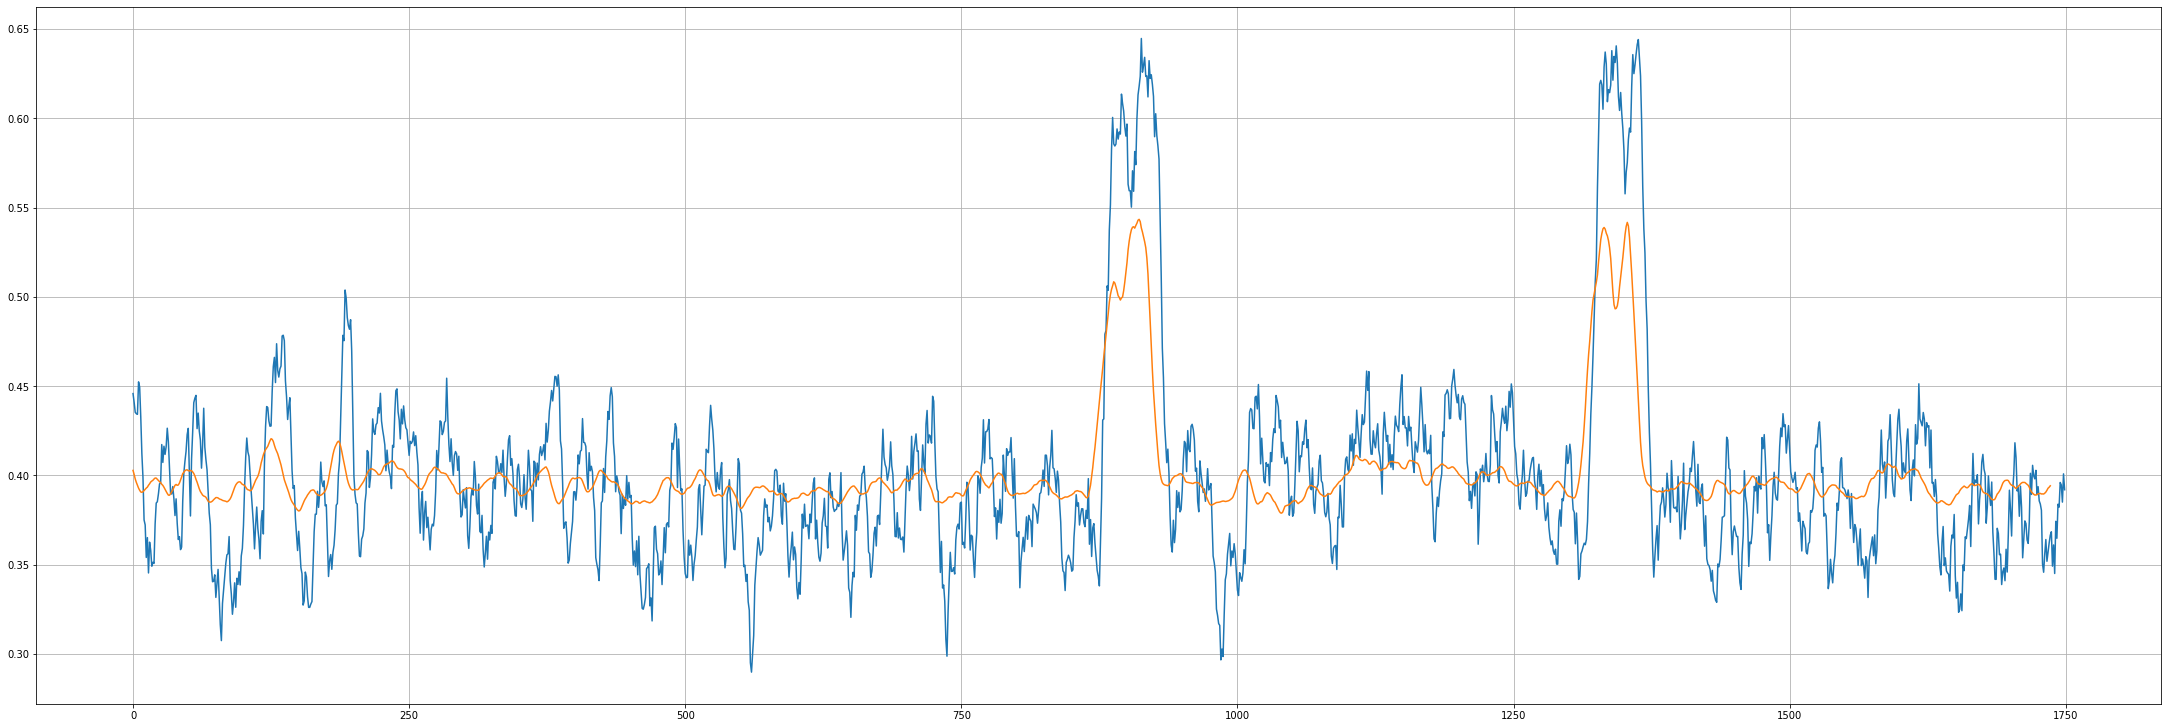

In [ ]:
fig, ax = plt.subplots(figsize=(30,10), constrained_layout=True)

ax.plot(df_act_mov['mov_average'],label='Actual')
ax.plot(df_pred_mov['mov_average'],label='Predicted')
ax.grid()
fig.savefig(f"{images_dir}/lstm_moving_machine1_vibration.png")

In [ ]:
cnn = Sequential()
cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_past, 4)))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Flatten())
cnn.add(Dense(50, activation='relu'))
cnn.add(Dense(4))
cnn.compile(optimizer='adam', loss='mse')
history=cnn.fit(x_train, y_train, epochs = 30, batch_size=100, validation_split=.2, verbose=1)

56/56 [==============================] - 1s 12ms/step - loss: 0.0135 - val_loss: 0.0151
Epoch 29/30
56/56 [==============================] - 1s 12ms/step - loss: 0.0134 - val_loss: 0.0152
Epoch 30/30
56/56 [==============================] - 1s 12ms/step - loss: 0.0135 - val_loss: 0.0150


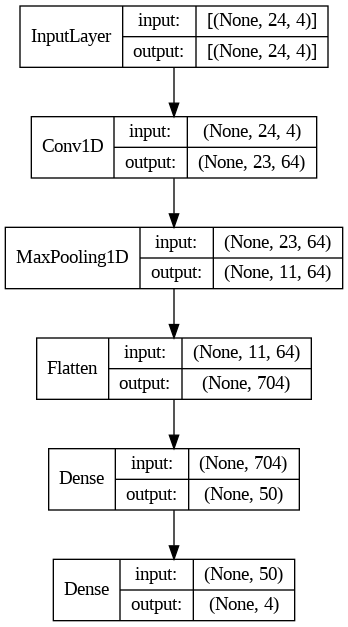

In [ ]:
tf.keras.utils.plot_model(cnn,  show_shapes=True,  show_layer_names=False)

55/55 [==============================] - 0s 2ms/step


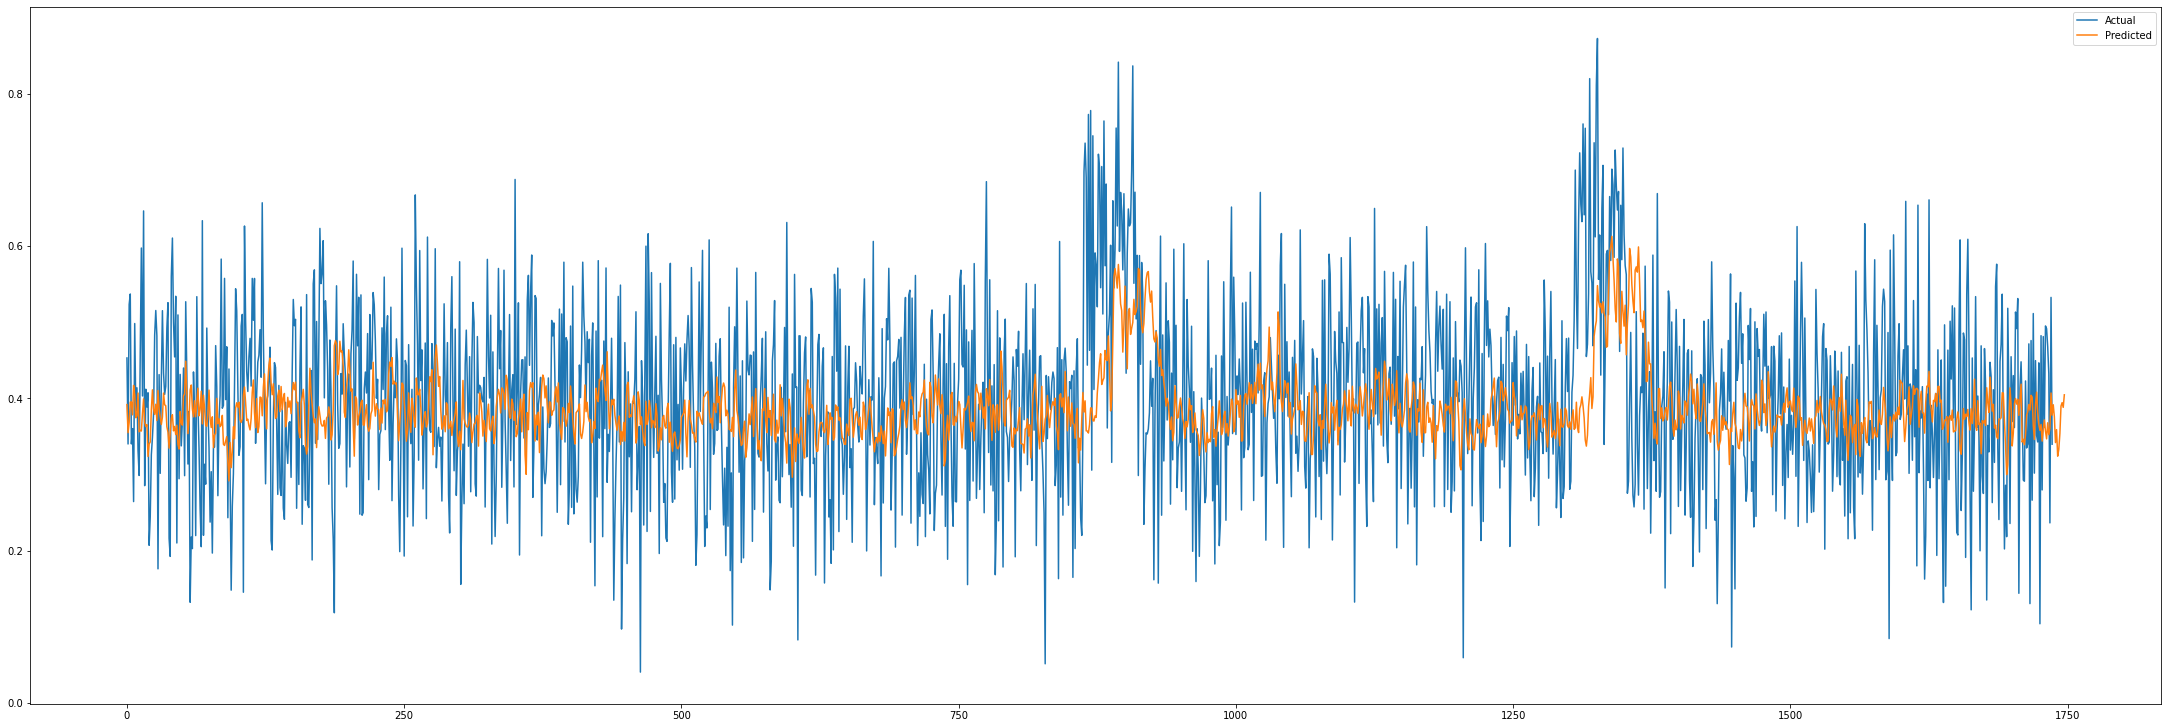

In [ ]:
y_pred_cnn=cnn.predict(x_test)

fig, ax = plt.subplots(figsize=(30,10), constrained_layout=True)
plt.plot(y[7000:,3],label='Actual')
plt.plot(y_pred_cnn[:,3],label='Predicted')
plt.legend()
plt.show()
fig.savefig(f"{images_dir}/cnn_machine1_vibration.png")

In [ ]:
score = cnn.evaluate(x_test, y_test, verbose=1)
print(score)

55/55 [==============================] - 0s 2ms/step - loss: 0.0148
0.014785357750952244


In [ ]:
rolling_window = 24

df_pred_cnn_mov = pd.DataFrame(y_pred_cnn)
df_pred_cnn_mov.head()
df_pred_cnn_mov['mov_average'] = df_pred_cnn_mov[3].rolling(rolling_window).mean()
df_pred_cnn_mov.dropna(inplace=True)
df_pred_cnn_mov.reset_index(drop=True, inplace=True)
df_pred_cnn_mov.head()

,0,1,2,3,mov_average
0,0.472091,0.598278,0.420322,0.355984,0.384828
1,0.450312,0.606858,0.411664,0.357950,0.382019
2,0.459111,0.604585,0.430679,0.356941,0.382201
3,0.468706,0.598889,0.433745,0.379904,0.383175
4,0.464583,0.573110,0.426795,0.399152,0.383528


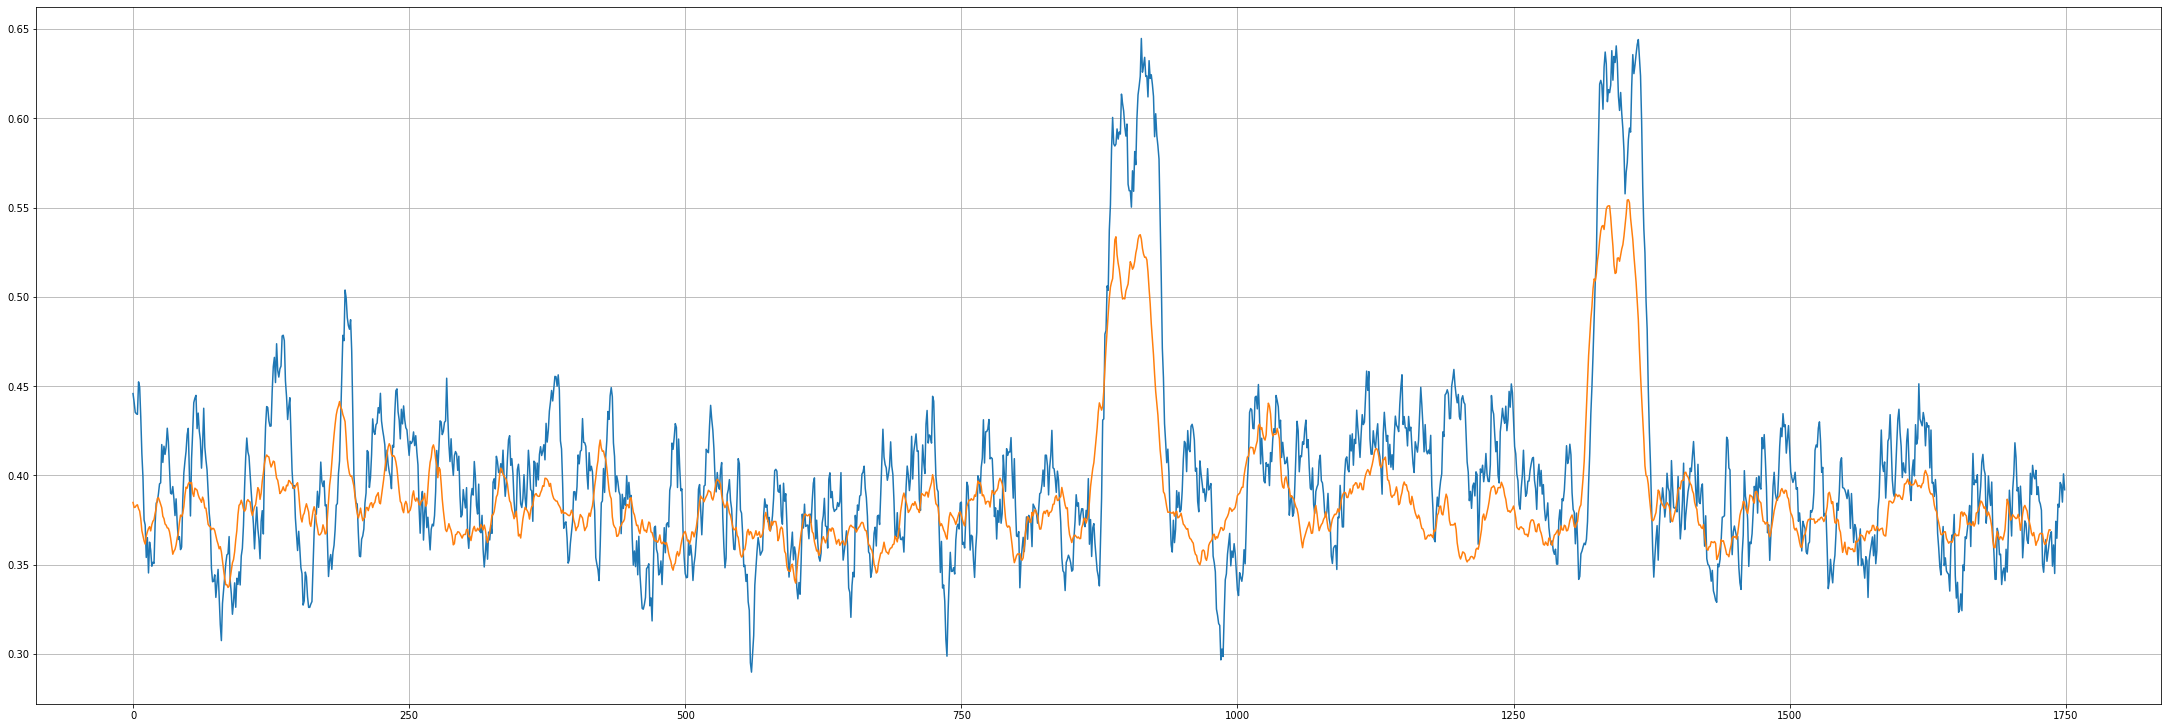

In [ ]:
fig, ax = plt.subplots(figsize=(30,10), constrained_layout=True)

ax.plot(df_act_mov['mov_average'],label='Actual')
ax.plot(df_pred_cnn_mov['mov_average'],label='Predicted')
ax.grid()
fig.savefig(f"{images_dir}/cnn_moving_machine1_vibration.png")